In [1]:
%matplotlib inline

from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors
import pandas as pd

<p style="font-family:courier;">1. Read the accidents with zones file skipping accidents with zone -1.</p>

In [2]:
df = pd.read_csv('../Data/Accidents_zones_dbscan.csv')
df = df[['longitud', 'latitud', 'zona']]
df = df[df['zona'] != -1]

<p style="font-family:courier;">2. Search the best K parameter for KNN testing the model with different K values and different train samples.</p>
<p style="font-family:courier;">2.1. We measure the errors for each K and sum the errors for each K along the 100 repetitions</p>

In [3]:
train_p = 0.6
reps = 100
k_errors = [0] * 101

for rep in range(reps):
    df['is_train'] = np.random.uniform(0, 1, len(df)) <= train_p
    df_train = df[df['is_train'] == True]
    df_test = df[df['is_train'] == False]
    
    for n_neighbors in range(1, 101):
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
        clf.fit(df_train[['latitud', 'longitud']], df_train['zona'])
        Z = clf.predict(df_test[['latitud', 'longitud']])
        err = (df_test['zona'] != Z).sum() / len(df_test)
        
        k_errors[n_neighbors] += err

k_errors = map(lambda x : x / reps, k_errors)

<p style="font-family:courier;"> 2.2. Plot the graphic of each K parameters with its error.</p>

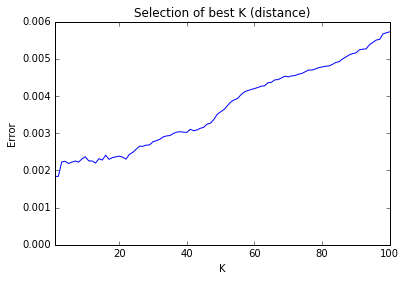

In [4]:
plt.title('Selection of best K (distance)')
plt.ylabel('Error')
plt.xlabel('K')
plt.xlim(1, 100)
plt.plot(k_errors)
plt.show()

<p style="font-family:courier;">2.3. Select the higher K with the minimum value in the list of k_errors.</p>

In [5]:
K = len(k_errors) - list(reversed(k_errors)).index(min(k_errors[1:])) - 1
print 'Best K: %d' % K

Best K: 2


<p style="font-family:courier;">3. Plot the decision boundary.</p>
<p style="font-family:courier;">3.1. We create color maps (a color for each zone).</p>

In [6]:
cmap = ListedColormap(plt.cm.Paired(np.linspace(0, 1, len(np.unique(Z)))))

<p style="font-family:courier;">3.2. We create a matrix of coordinates and assig each element of the matrix to one zone with the KNN algorithm and the K parameter calculated before.</p>

In [7]:
clf = neighbors.KNeighborsClassifier(2, weights = 'distance')
clf.fit(df[['latitud', 'longitud']], df['zona'])

lat_min, lat_max = df['latitud'].min() - 0.01, df['latitud'].max() + 0.01
lon_min, lon_max = df['longitud'].min() - 0.01, df['longitud'].max() + 0.01

lats, lons = np.meshgrid(np.arange(lat_min, lat_max, 0.001),
                         np.arange(lon_min, lon_max, 0.001))

Z = clf.predict(np.c_[lats.ravel(), lons.ravel()])
Z = Z.reshape(lats.shape)

<p style="font-family:courier;">3.3. Plot the map with colors and the training points.</p>

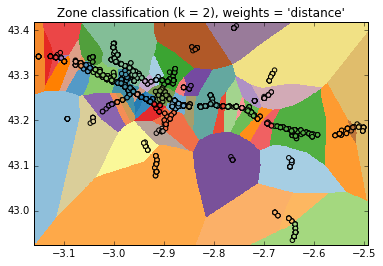

In [8]:
plt.figure()
plt.pcolormesh(lons, lats, Z, cmap = cmap)
plt.scatter(df['longitud'], df['latitud'], c=df['zona'], cmap = cmap)
plt.xlim(lons.min(), lons.max())
plt.ylim(lats.min(), lats.max())
plt.title("Zone classification (k = %d), weights = 'distance'" % (2))

plt.show()

<p style="font-family:courier;">4. Predict the zone of the works based on the KNN model with the K fixed before.</p>

In [21]:
df_works = pd.read_csv('../Data/Works_filtered.csv')

clf_works = neighbors.KNeighborsClassifier(K, weights='distance')
clf_works.fit(df[['latitud', 'longitud']], df['zona'])
Z = clf_works.predict(df_works[['latitud', 'longitud']])

<p style="font-family:courier;">5. Store the results.</p>

In [22]:
df_works['zona'] = Z
df_works.to_csv('../Data/Works_zones.csv')